In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import os
import json
import uuid

import rdkit
print(rdkit.__version__)
import lwreg
from lwreg import standardization_lib
from lwreg import utils
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
import warnings

# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)



2023.03.3


In [3]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
SELECT cs_mdfps_schema.confid_data.conf_id AS confid,
       public.conformers.molblock,
       cs_mdfps_schema.experimental_data.vp,
       cs_mdfps_schema.mdfp_experiment_data.mdfp
FROM cs_mdfps_schema.confid_data
INNER JOIN public.conformers
ON cs_mdfps_schema.confid_data.conf_id = public.conformers.conf_id
INNER JOIN cs_mdfps_schema.experimental_data
ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
INNER JOIN cs_mdfps_schema.mdfp_experiment_data
ON cs_mdfps_schema.confid_data.conf_id = cs_mdfps_schema.mdfp_experiment_data.conf_id
WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835';
'''
# Execute the SQL query
cur.execute(sql_query)
results = cur.fetchall()
mdfps = [json.loads(r[3]['mdfp']) for r in results]
vps = [r[2] for r in results]
molblokcs = [r[1] for r in results]
mols = [Chem.MolFromMolBlock(m) for m in molblokcs]


[14:12:02] Warning: molecule is tagged as 3D, but all Z coords are zero


In [5]:
from rdkit.Chem.Descriptors import CalcMolDescriptors
MolDescriptors_vectors_ = [list(CalcMolDescriptors(m).values()) for m in mols]

In [21]:
#make df with each descriptor as a column and one column for the vp
vps = [r[2] for r in results]
confids = [r[0] for r in results]
df_descriptors = pd.DataFrame(MolDescriptors_vectors_, columns = list(CalcMolDescriptors(mols[0]).keys()))
df_descriptors['vp'] = vps
df_descriptors['confid'] = confids  
top_features = ['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'BCUT2D_CHGHI', 'MinPartialCharge', 'MaxPartialCharge', 'MinEStateIndex', 'FpDensityMorgan1', 'BCUT2D_MRLOW', 'BCUT2D_MWLOW', 'BalabanJ', 'BCUT2D_MWHI', 'BCUT2D_LOGPHI', 'Kappa3', 'BCUT2D_LOGPLOW', 'MolWt', 'BCUT2D_CHGLO', 'PEOE_VSA6', 'FpDensityMorgan3', 'FpDensityMorgan2', 'PEOE_VSA7', 'VSA_EState3', 'PEOE_VSA8', 'BertzCT', 'MinAbsPartialCharge', 'BCUT2D_MRHI', 'VSA_EState8', 'AvgIpc', 'EState_VSA3', 'TPSA', 'VSA_EState7', 'EState_VSA6', 'VSA_EState4', 'VSA_EState5', 'Chi3v', 'PEOE_VSA9', 'EState_VSA5', 'MolLogP', 'Kappa2', 'Chi2n', 'SMR_VSA5', 'MaxAbsPartialCharge']
df_descriptors['mdfp'] = mdfps
#disect the mdfps
mdfp_keys_full = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median'] 
mdfps = df_descriptors['mdfp'].tolist()

for i,key in enumerate(mdfp_keys_full):
    df_descriptors[key] = [mdfps[j][i] for j in range(len(mdfps))]

In [22]:
import tqdm
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
output = ([], [],[])
kf = KFold(n_splits=5)
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    "objective" : 'reg:squarederror',
}
X = df_descriptors[top_features]
y = df_descriptors['vp']
confids = df_descriptors['confid']
for train, test in tqdm.tqdm(kf.split(X)):
    train_x = np.array(X)[train]
    train_y = np.array(y)[train]
    test_x = np.array(X)[test]
    test_y = np.array(y)[test]
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)
    confids_test = np.array(confids)[test]

    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    pp = model.predict(dtest)

    output[0].append(test_y)
    output[1].append(pp)
    output[2].append(confids_test)

5it [00:00,  5.26it/s]


In [37]:
#make df
from functools import reduce
real = reduce(lambda x,y: np.concatenate((x,y)), output[0])
pred = reduce(lambda x,y: np.concatenate((x,y)), output[1])
confids = reduce(lambda x,y: np.concatenate((x,y)), output[2])
df_predictions = pd.DataFrame({'real':real, 'pred':pred, 'confid':confids})
#merge with df_descriptors
df_predictions = df_predictions.merge(df_descriptors, on='confid')
df_predictions['abs_error'] = np.abs(df_predictions['real'] - df_predictions['pred'])
df_predictions.to_csv('002_delta_learning.csv')

In [32]:

import xgboost as xgb
X = df_predictions[mdfp_keys_full]
y = df_predictions['abs_error']
dtrain = xgb.DMatrix(X, label=y)

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    "objective" : 'reg:squarederror',
}

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(2,7)
    for min_child_weight in range(5,10)
]

min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'mae', "rmse"},
        early_stopping_rounds=10,
        verbose_eval=False
    )
    # Update best MAE
    mean_mae = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=2, min_child_weight=5
	MAE 0.8556613252431762 for 14 rounds
CV with max_depth=2, min_child_weight=6
	MAE 0.8887256772781068 for 2 rounds
CV with max_depth=2, min_child_weight=7
	MAE 0.8881949477828692 for 2 rounds
CV with max_depth=2, min_child_weight=8
	MAE 0.8881949477828692 for 2 rounds
CV with max_depth=2, min_child_weight=9
	MAE 0.8877672470564686 for 2 rounds
CV with max_depth=3, min_child_weight=5
	MAE 0.8811346678276635 for 2 rounds
CV with max_depth=3, min_child_weight=6
	MAE 0.8826976325218837 for 2 rounds
CV with max_depth=3, min_child_weight=7
	MAE 0.8818339659692311 for 2 rounds
CV with max_depth=3, min_child_weight=8
	MAE 0.8818986256560111 for 2 rounds
CV with max_depth=3, min_child_weight=9
	MAE 0.881080841889345 for 2 rounds
CV with max_depth=4, min_child_weight=5
	MAE 0.8812139413914022 for 2 rounds
CV with max_depth=4, min_child_weight=6
	MAE 0.8683194704087593 for 3 rounds
CV with max_depth=4, min_child_weight=7
	MAE 0.8785094444092477 for 2 rounds

In [33]:
#lets see if we can take the absolute error and predict the vp using MDFPs

import tqdm
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
output = ([], [],[])
kf = KFold(n_splits=5)
params = {
    # Parameters that we are going to tune.
    'max_depth':4,
    'min_child_weight': 8,
    'eta':.5,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    "objective" : 'reg:squarederror',
}
X = df_predictions[mdfp_keys_full]
y = df_predictions['abs_error']
confids = df_predictions['confid']
for train, test in tqdm.tqdm(kf.split(X)):
    train_x = np.array(X)[train]
    train_y = np.array(y)[train]
    test_x = np.array(X)[test]
    test_y = np.array(y)[test]
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)
    confids_test = np.array(confids)[test]

    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    pp = model.predict(dtest)

    output[0].append(test_y)
    output[1].append(pp)
    output[2].append(confids_test)

5it [00:00, 18.82it/s]


In [34]:
#get results
from functools import reduce
real = reduce(lambda x,y: np.concatenate((x,y)), output[0])
pred = reduce(lambda x,y: np.concatenate((x,y)), output[1])
confids = reduce(lambda x,y: np.concatenate((x,y)), output[2])

rmse:  0.8906479489468588
r2:  0.16515239935907888
mae:  0.5606223291088083


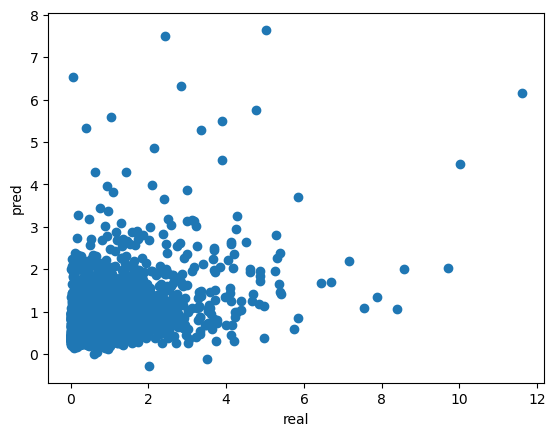

In [35]:
#pred real vs pred
import matplotlib.pyplot as plt
plt.scatter(real, pred)
#print rmse, r2 and mae
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print('rmse: ', np.sqrt(mean_squared_error(real, pred)))
print('r2: ', r2_score(real, pred))
print('mae: ', mean_absolute_error(real, pred))
plt.xlabel('real')
plt.ylabel('pred')
plt.show()
